In [199]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import  RidgeCV
import shap
import numpy as np
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt


In [200]:
def get_score(model, feature, target):
    pred = model.predict(feature)
    score = pd.DataFrame(pred, columns=['Prediction'], index=feature.index)
    score['GroundTruth'] = np.array(target)
    score['AbsoluteError'] = abs(score['GroundTruth'] - score['Prediction'])
    return score

def get_doubtful_values(score):
    return score[score['AbsoluteError'] > 1.5]

def get_truthful_values(score):
    return score[score['AbsoluteError'] < 0.5]

In [201]:
data = pd.read_csv("data/data_cleaned.csv")
data = data.drop(["Unnamed: 0"], axis=1)

In [202]:
y = data["OverallQual"]
X = data.drop(["OverallQual", 'SalePrice'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=100, stratify=y )

ridge = RidgeCV()
ridge.fit(X_train, y_train)
print(ridge.score(X_test, y_test))
y_pred = ridge.predict(X)
y_score = get_score(ridge, X, y)
y_correct = get_truthful_values(y_score)

0.7458862156225882


In [203]:
'''
Experiment:
- Original dataset, get doubtful value
- Corrupt this attrubute (the non-doubtful)
- See if the model discover the pattern.
'''

explainer = shap.Explainer(ridge, X, algorithm="linear", seed=100)
shap_values = explainer(X)

In [204]:
"""
Get data that only include the correct prediction.
Two indexes need to be kept.
"""
data_correct = data.iloc[y_correct.index]
data_correct['data_index'] = data_correct.index
data_correct = data_correct.reset_index(drop=True)
data_correct['index'] = data_correct.index
data_correct.set_index(['index', 'data_index'], inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [205]:
"""
Corrupt OverallQual on data_correct dataframe.
"""
corruption_list = []
old_new_value = OrderedDict()
OverallQual_sample_fraction = 0.4

data_to_corrupt = data_correct.copy()

corruption_index_list = sorted(data_to_corrupt.sample(frac = OverallQual_sample_fraction, random_state=1).index)
for i in corruption_index_list:
    old = data_to_corrupt.loc[i, 'OverallQual']
    new = np.random.randint(1, 11, 1)[0]
    while abs(old - new) != 4:
        new = np.random.randint(1, 11, 1)[0]
    data_to_corrupt.loc[i, 'OverallQual'] = new
    corruption_list.append(i)
    old_new_value[i[0]] = (old, new)
# print(old_new_value)
print(len(corruption_list))
# sorted(corruption_list)

y_corrupted = data_to_corrupt["OverallQual"]
X_corrupted = data_to_corrupt.drop(["OverallQual", 'SalePrice'], axis=1)
X_train_cor, X_test_cor, y_train_cor, y_test_cor = train_test_split(X_corrupted, y_corrupted, test_size=0.1,random_state=100)
ridge_corrupt = RidgeCV()
ridge_corrupt.fit(X_train_cor, y_train_cor)
print(ridge_corrupt.score(X_test_cor, y_test_cor))

630
-0.006241222724474804


In [206]:
y_corrupted_score = get_score(ridge_corrupt, X_corrupted, y_corrupted)
y_corrupted_doubt = get_doubtful_values(y_corrupted_score)
y_corrupted_doubt = y_corrupted_doubt.rename(columns={'GroundTruth' : 'CorruptedTruth', 'AbsoluteError': 'CorruptedError'})
y_corrupted_doubt['GroundTruth'] = y_corrupted_doubt.index.get_level_values(1).map(y[y_corrupted_doubt.index.get_level_values(1)])
y_corrupted_doubt['Corrupted'] = y_corrupted_doubt['GroundTruth'] != y_corrupted_doubt['CorruptedTruth']
y_corrupted_doubt['OrgPredict'] = y_corrupted_doubt.index.get_level_values(1).map(y_score.loc[y_corrupted_doubt.index.get_level_values(1)]['Prediction'])
y_corrupted_doubt = y_corrupted_doubt[['Prediction', 'OrgPredict', 'CorruptedTruth', 'GroundTruth', 'Corrupted', 'CorruptedError']]
y_corrupted_doubt[y_corrupted_doubt['Corrupted'] == True]

,,Prediction,OrgPredict,CorruptedTruth,GroundTruth,Corrupted,CorruptedError
index,data_index,,,,,,
3,4,5.738624,7.643465,4,8,True,1.738624
6,9,5.906549,5.347468,9,5,True,3.093451
8,11,7.614183,9.427897,5,9,True,2.614183
9,12,5.127068,4.863201,1,5,True,4.127068
10,16,4.909158,5.851593,2,6,True,2.909158
...,...,...,...,...,...,...,...
1559,2881,4.607577,3.892613,8,4,True,3.392423
1561,2883,5.460012,5.585619,10,6,True,4.539988
1562,2884,4.792274,3.359596,7,3,True,2.207726


In [207]:
shap.initjs()
explainer_corruption = shap.Explainer(ridge_corrupt, X_corrupted, algorithm="linear", seed=100)
shap_values_corruption = explainer_corruption(X_corrupted)

In [208]:

overallQual_explaination = {}

for i in range(len(shap_values_corruption)):
    overallQual = int(data_to_corrupt.iloc[i]['OverallQual'])
    if overallQual not in overallQual_explaination:
        overallQual_explaination[overallQual] = shap.Explanation(values=shap_values_corruption.values[i], base_values=shap_values_corruption.base_values[i], data=shap_values_corruption.data[i], feature_names=shap_values_corruption.feature_names)
    else:
        overallQual_explaination[overallQual].base_values = np.append(overallQual_explaination[overallQual].base_values, shap_values_corruption.base_values[i])
        overallQual_explaination[overallQual].values = np.vstack([overallQual_explaination[overallQual].values, shap_values_corruption.values[i]])
        overallQual_explaination[overallQual].data = np.vstack([overallQual_explaination[overallQual].data, shap_values_corruption.data[i]])


8


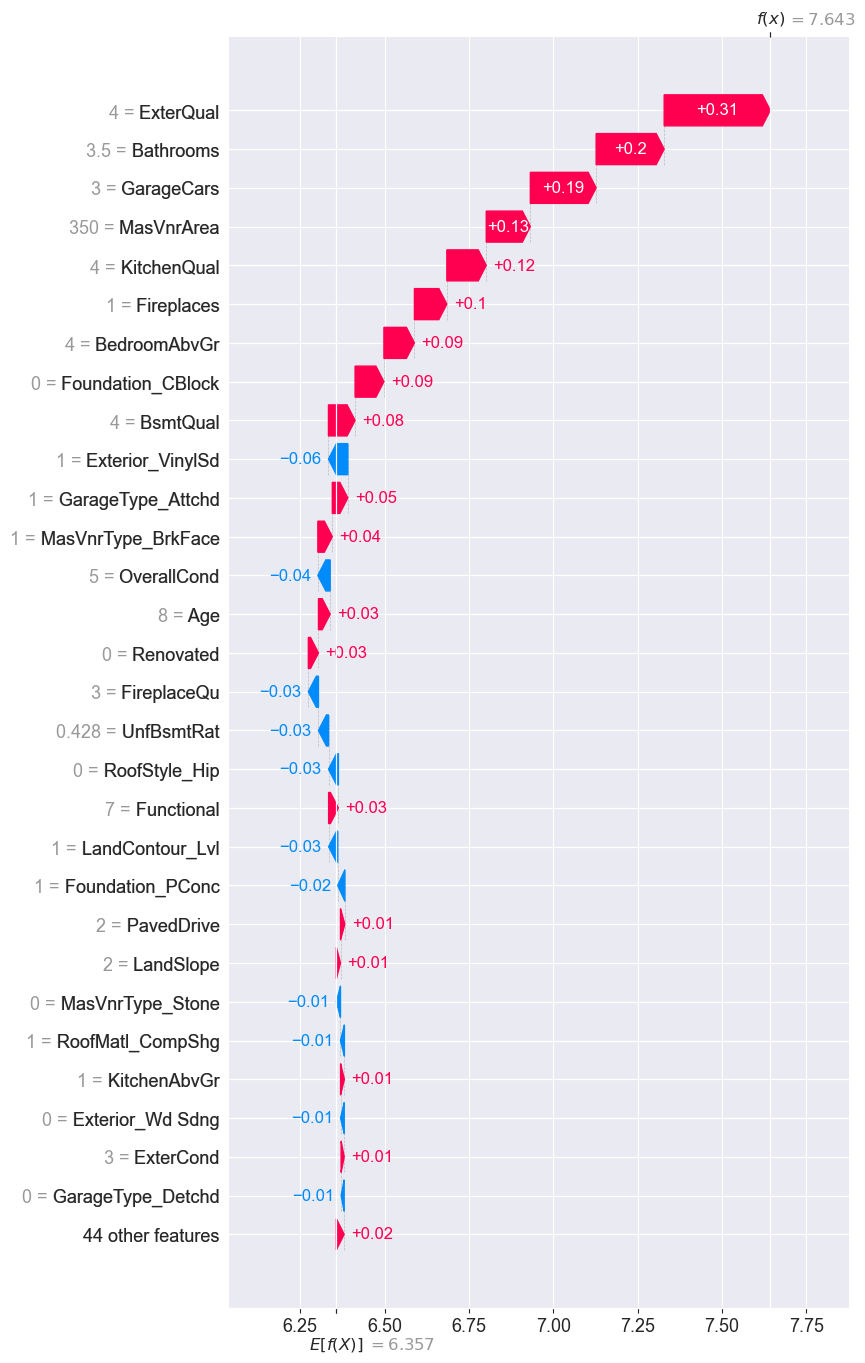

In [214]:
print(y[corruption_list[0][1]])
shap.plots.waterfall(shap_values[corruption_list[0][1]], max_display=30)

data_index
4    4
Name: OverallQual, dtype: int64


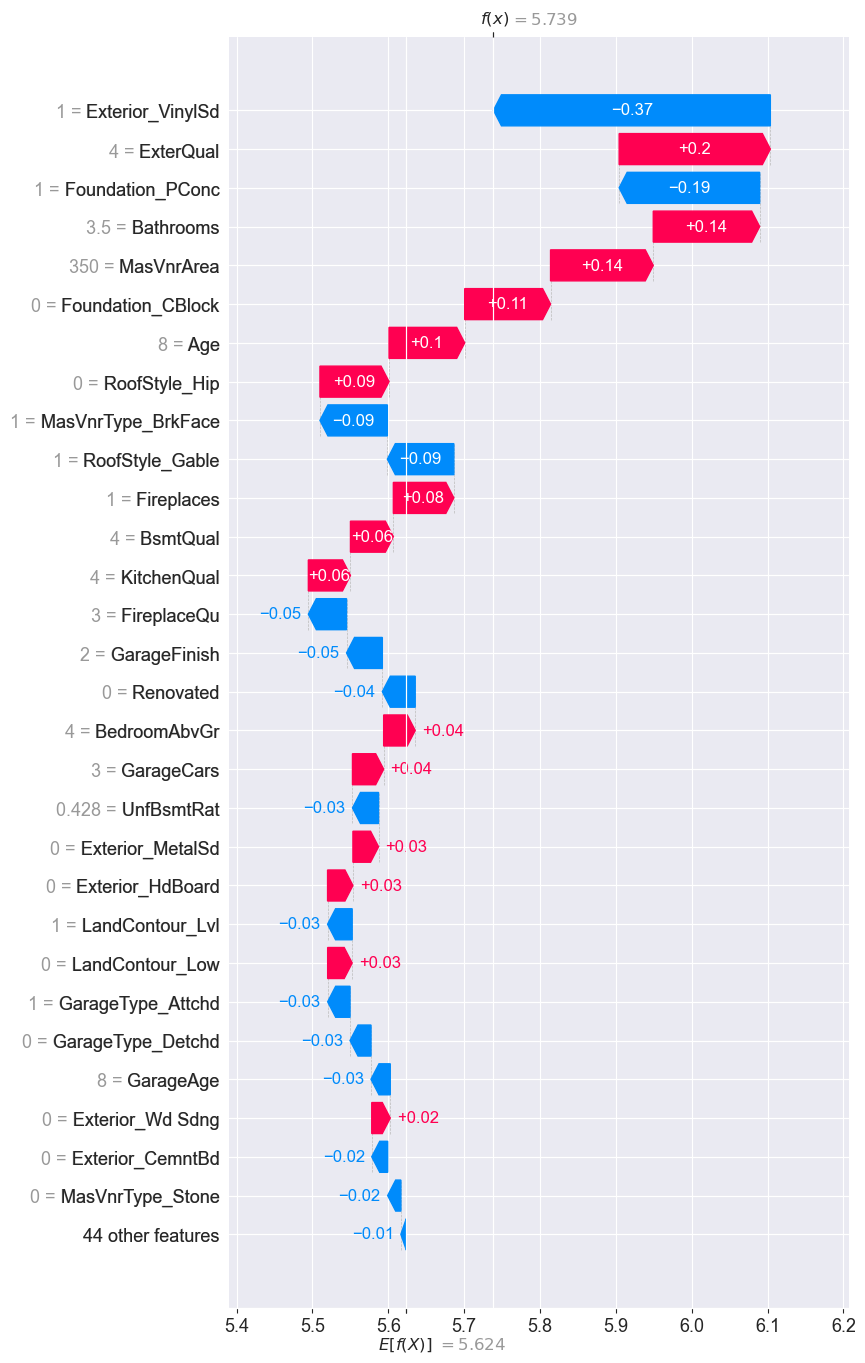

In [213]:
print(y_corrupted[corruption_list[0][0]])
shap.plots.waterfall(shap_values_corruption[corruption_list[0][0]], max_display=30)

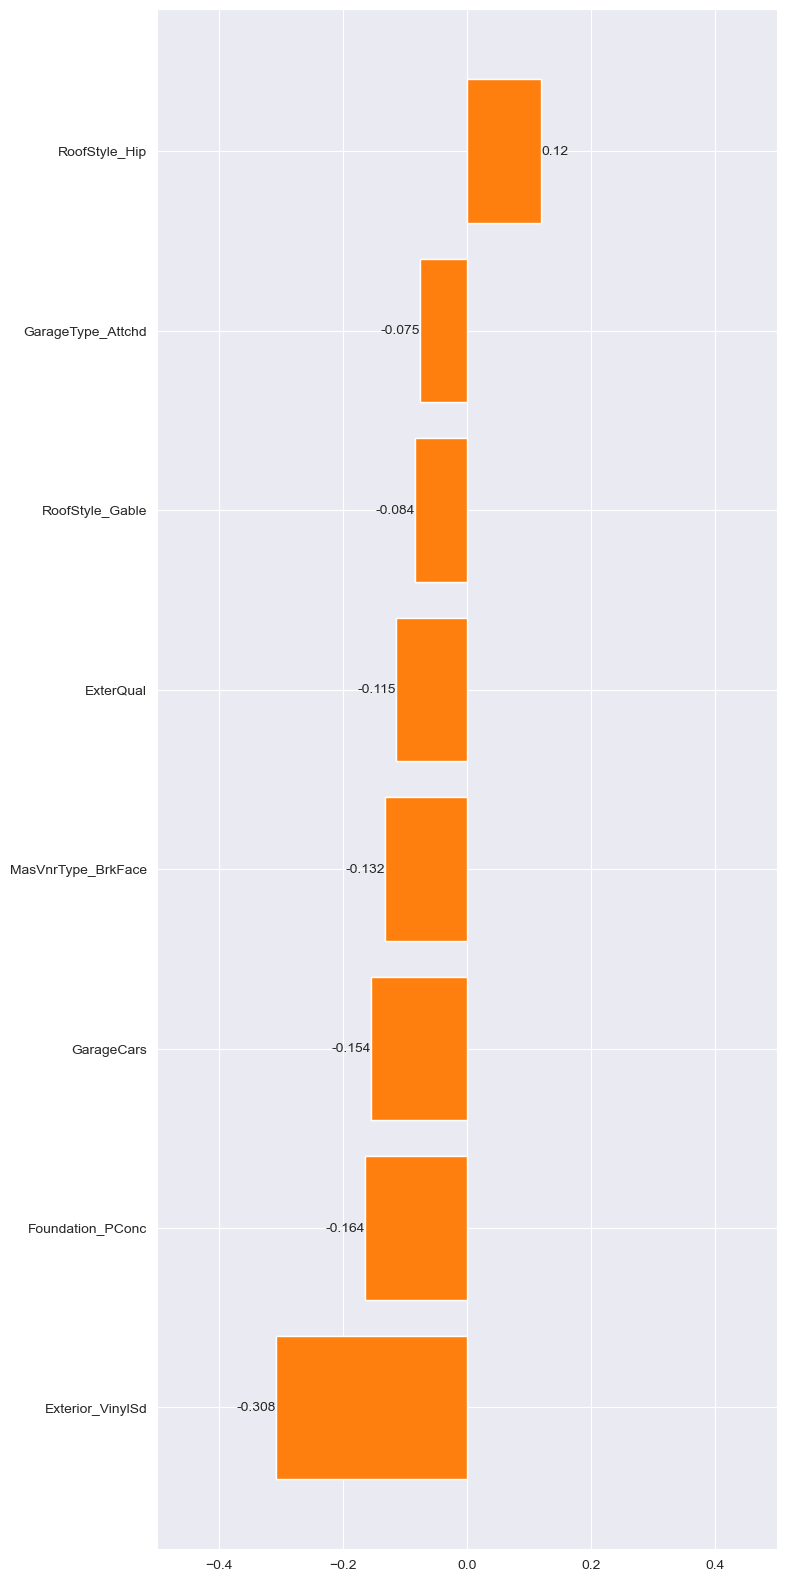

In [218]:
'''
Plot differences in explanation between corrupted and original data.
'''
values= (shap_values_corruption[corruption_list[0][0]].values - shap_values[corruption_list[0][1]].values).round(3)
df_corrupt = pd.DataFrame([values], columns=shap_values_corruption.feature_names).sort_values(by=0, axis=1, ascending=True)
df_corrupt = df_corrupt.loc[:,~(abs(df_corrupt.iloc[0]) < 0.075)]

plt.figure(figsize=(8, 20))
plt.barh(df_corrupt.columns, df_corrupt.iloc[0])
plt.bar_label(plt.barh(df_corrupt.columns, df_corrupt.iloc[0]))
plt.xlim(-0.5, 0.5)
plt.show()

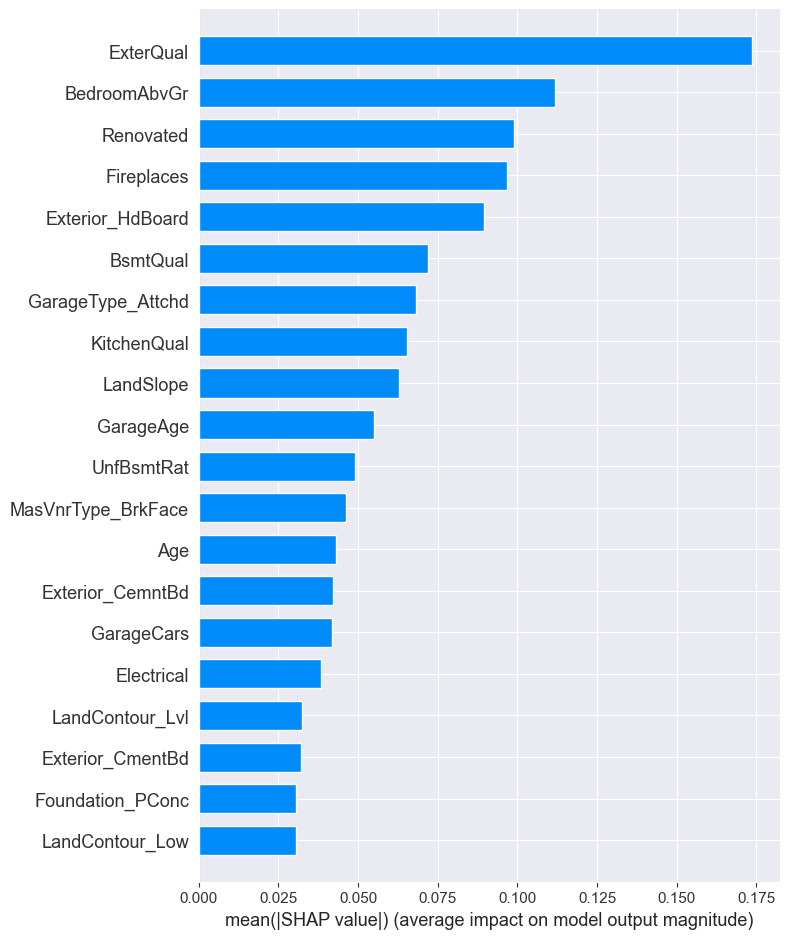

In [191]:
shap.summary_plot(overallQual_explaination[2], plot_type='bar')

In [192]:
"""
Make explanation locally for each OverallQual:
i.e., how features contribute to each OverallQual values

- How many times it predict correct value instead of corruption value?
- Better
- Merging two figures (x)

Design experiment:

rough value on from what point the value degrades.
increase corruption percentage

"""

'\nMake explanation locally for each OverallQual:\ni.e., how features contribute to each OverallQual values\n\n- How many times it predict correct value instead of corruption value?\n- Better\n- Merging two figures (x)\n\nDesign experiment:\n\nrough value on from what point the value degrades.\nincrease corruption percentage\n\n'

In [193]:
new = ["New" if shap_values[i,"Renovated"].data == 1 else "Old" for i in range(shap_values.shape[0])]
# shap.plots.bar(shap_values.cohorts(new).abs.mean(0),max_display=30)


<BarContainer object of 42 artists>

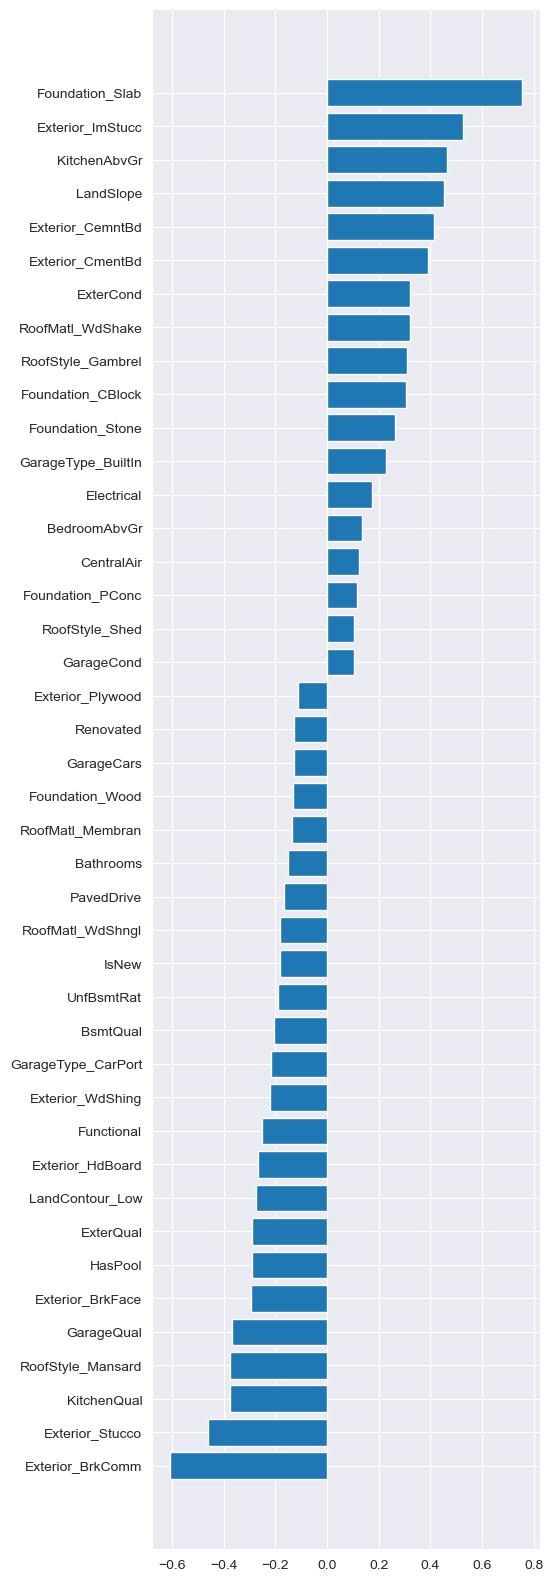

In [194]:
df = pd.DataFrame([ridge.coef_], columns=ridge.feature_names_in_).sort_values(by=0, axis=1, ascending=True)
df_corrupt = pd.DataFrame([ridge_corrupt.coef_], columns=ridge_corrupt.feature_names_in_).sort_values(by=0, axis=1, ascending=True)
df_diff = (df_corrupt - df).sort_values(by=0, axis=1, ascending=True)
df_diff = df_diff.loc[:,~(abs(df_diff.iloc[0]) < 0.1)]
plt.figure(figsize=(5, 20))
plt.barh(df_diff.columns, df_diff.iloc[0])